<a href="https://colab.research.google.com/github/PaulinaRuizB/Machine_Learning_Theory/blob/main/Task_1_TAM_Euclidean_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distancia Euclidiana

La **distancia euclidiana** es la medida más común para calcular qué tan lejos están dos puntos en un espacio.  
Se basa en el **Teorema de Pitágoras** y mide la longitud de la línea recta que une ambos puntos.

## Definición general

Si tenemos dos vectores en un espacio de \(n\) dimensiones:

$$ \vec{u} = (u_1, u_2, \dots, u_n), \quad
\vec{v} = (v_1, v_2, \dots, v_n)$$

La **distancia euclidiana** entre ellos se define como:

$$
d(\vec{u}, \vec{v}) \;=\; \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}
$$

En visión por computador y machine learning, esta fórmula se usa para medir **similitud** entre imágenes transformadas en vectores:  
**Distancia pequeña = más parecidos**  
**Distancia grande = menos parecidos**


In [4]:
from google.colab import files
uploaded = files.upload()  # Sube A.jpg, B.jpg, C.jpg (o los nombres que quieras)


Saving damiano3.jpg to damiano3.jpg
Saving brendon1.jpg to brendon1.jpg
Saving brendon.jpg to brendon.jpg


## Librerías

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import cv2

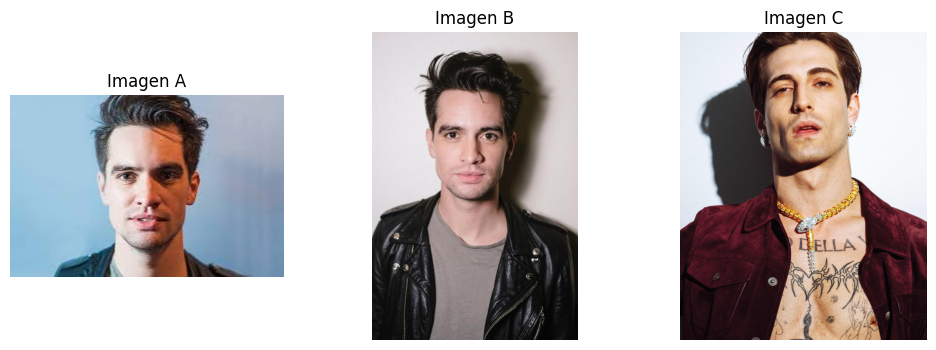

In [3]:
# Rutas de tus imágenes
A, B, C = "brendon.jpg", "brendon1.jpg", "damiano3.jpg"

# Cargar con PIL (corrigiendo orientación EXIF)
imgA = Image.open(A)
imgB = Image.open(B)
imgC = Image.open(C)

# Mostrar en una fila
plt.figure(figsize=(12,4))
for i, (im, title) in enumerate(zip([imgA, imgB, imgC], ["Imagen A", "Imagen B", "Imagen C"])):
    plt.subplot(1,3,i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
plt.show()


## SIn procesamiento

In [6]:
def img_to_vec_raw(path, size=(224,224)):
    # EXIF rotate (para fotos de móvil), RGB para tener formato consistente
    img = Image.open(path)
    img = ImageOps.exif_transpose(img).convert("RGB")
    # Redimensionar SIN mantener relación (solo para igualar tamaño)
    img = img.resize(size)
    arr = np.asarray(img, dtype=np.float32)  # rango 0..255
    return arr.ravel()  # vector 1D

def l2(a,b):
    return float(np.linalg.norm(a-b))

A, B, C = "brendon.jpg", "brendon1.jpg", "damiano3.jpg"  # pon tus rutas
vA, vB, vC = img_to_vec_raw(A), img_to_vec_raw(B), img_to_vec_raw(C)

dAB = l2(vA, vB)
dAC = l2(vA, vC)

print("=== Distancias Euclidianas (más pequeño = más parecido) ===")
print("d(A,B)=", dAB)
print("d(A,C)=", dAC)
print("→ B más similar a A" if dAB < dAC else "→ C más similar a A")

=== Distancias Euclidianas (más pequeño = más parecido) ===
d(A,B)= 36480.12109375
d(A,C)= 43728.42578125
→ B más similar a A


## Con procesamiento

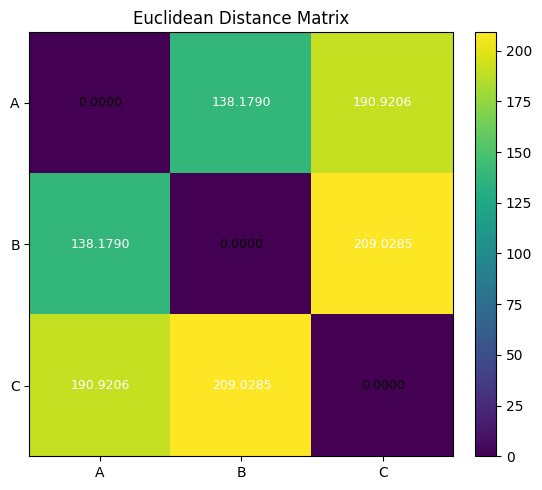

=== Distancias Euclidianas (menor = más parecido) ===
d(A,B) = 138.1790
d(A,C) = 190.9206
d(B,C) = 209.0285

→ Par más similar: A-B (d = 138.1790)
→ Con respecto a A, B es más parecido (d(A,B)=138.1790 < d(A,C)=190.9206)

Ranking de similitud (1 = más similar):
1. A-B: 138.1790
2. A-C: 190.9206
3. B-C: 209.0285


In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# =========================
# Utilidades y preprocesado
# =========================
def pil_to_cv(img_pil):
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def cv_to_pil(img_cv):
    return Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

def zscore(img):
    # img flotante en escala [0,1]
    m, s = img.mean(), img.std()
    if s < 1e-6:  # evitar división por cero
        return img * 0.0
    return (img - m) / s

# Detector Haar (básico)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                     "haarcascade_frontalface_default.xml")

def detect_face_bbox(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1,
                                          minNeighbors=5, minSize=(60,60))
    if len(faces) == 0:
        return None
    # cara más grande
    x, y, w, h = max(faces, key=lambda f: f[2]*f[3])
    return x, y, w, h

def preprocess_for_l2(path, out_size=(224,224),
                      expand=1.4,           # amplía el cuadro de la cara
                      bg_gray=0,            # fondo uniforme (0=negro, 255=blanco)
                      apply_blur=True):     # suavizado ligero
    # 1) Abrir y corregir orientación
    img = Image.open(path)
    img = ImageOps.exif_transpose(img).convert("RGB")
    bgr = pil_to_cv(img)

    # 2) Detectar cara y definir crop cuadrado expandido
    bbox = detect_face_bbox(bgr)
    h, w = bgr.shape[:2]
    if bbox is None:
        # fallback: cuadrado centrado
        side = min(w, h)
        cx, cy = w // 2, h // 2
        half = side // 2
        x1, y1 = cx - half, cy - half
        x2, y2 = cx + half, cy + half
    else:
        x, y, w0, h0 = bbox
        cx, cy = x + w0 // 2, y + h0 // 2
        side = int(max(w0, h0) * expand)
        half = side // 2
        x1, y1 = cx - half, cy - half
        x2, y2 = cx + half, cy + half

    # 3) Padding si se sale del marco
    pad_left   = max(0, -x1)
    pad_top    = max(0, -y1)
    pad_right  = max(0, x2 - w)
    pad_bottom = max(0, y2 - h)
    if pad_left or pad_top or pad_right or pad_bottom:
        bgr = cv2.copyMakeBorder(
            bgr, pad_top, pad_bottom, pad_left, pad_right,
            borderType=cv2.BORDER_CONSTANT, value=(bg_gray, bg_gray, bg_gray)
        )
        x1 += pad_left; x2 += pad_left
        y1 += pad_top;  y2 += pad_top

    crop = bgr[max(0, y1):min(bgr.shape[0], y2),
               max(0, x1):min(bgr.shape[1], x2)]

    # 4) Redimensionar intermedio
    crop = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)

    # 5) Máscara elíptica (fondo uniforme)
    mask = np.zeros((256, 256), np.uint8)
    rx, ry = 110, 130
    cv2.ellipse(mask, (128, 128), (int(rx), int(ry)),
                0, 0, 360, 255, -1)
    bg = np.full_like(crop, bg_gray, dtype=np.uint8)
    crop = np.where(mask[..., None] == 255, crop, bg)

    # 6) Escala de grises + CLAHE
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # 7) Normalización a [0,1] y z-score
    gray = gray.astype(np.float32) / 255.0
    gray = zscore(gray)

    # 8) Suavizado opcional
    if apply_blur:
        gray = cv2.GaussianBlur(gray, (3,3), 0.6)

    # 9) Redimension final y vectorización
    gray = cv2.resize(gray, out_size, interpolation=cv2.INTER_LINEAR)
    vec = gray.ravel().astype(np.float32)

    # (Opcional) Normalización L2 para que L2 ≈ sqrt(2 - 2*cos)
    # vec /= (np.linalg.norm(vec) + 1e-8)

    return vec

def l2(a, b):
    return float(np.linalg.norm(a - b))

# =========================
# Configura tus 3 imágenes
# =========================
A_path = "brendon.jpg"
B_path = "brendon1.jpg"
C_path = "damiano3.jpg"

# Preprocesar y vectorizar
vA = preprocess_for_l2(A_path)
vB = preprocess_for_l2(B_path)
vC = preprocess_for_l2(C_path)

# =========================
# Distancias por pares
# =========================
names = ["A", "B", "C"]
vecs  = [vA, vB, vC]

n = len(vecs)
D = np.zeros((n, n), dtype=np.float32)
for i in range(n):
    for j in range(n):
        if i == j:
            D[i, j] = 0.0
        else:
            D[i, j] = l2(vecs[i], vecs[j])

# =========================
# Heatmap con anotaciones
# =========================
plt.figure(figsize=(6, 5))
im = plt.imshow(D, cmap="viridis")
plt.title("Euclidean Distance Matrix")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n), names)
plt.yticks(range(n), names)

# Anotar cada celda
for i in range(n):
    for j in range(n):
        text = f"{D[i, j]:.4f}"
        # contraste del texto (blanco si fondo oscuro)
        color = "white" if im.norm(D[i, j]) > 0.6 else "black"
        plt.text(j, i, text, ha="center", va="center", color=color, fontsize=9)

plt.tight_layout()
plt.show()

# =========================
# Reporte textual
# =========================
# Par más similar (mínimo fuera de la diagonal)
upper_idx = np.triu_indices(n, k=1)
flat_vals = D[upper_idx]
min_pos = np.argmin(flat_vals)
i, j = upper_idx[0][min_pos], upper_idx[1][min_pos]
print("=== Distancias Euclidianas (menor = más parecido) ===")
for (p, q) in [(0,1), (0,2), (1,2)]:
    print(f"d({names[p]},{names[q]}) = {D[p,q]:.4f}")

print(f"\n→ Par más similar: {names[i]}-{names[j]} (d = {D[i,j]:.4f})")

# También: ¿B o C es más parecido a A?
if D[0,1] < D[0,2]:
    print(f"→ Con respecto a A, B es más parecido (d(A,B)={D[0,1]:.4f} < d(A,C)={D[0,2]:.4f})")
elif D[0,1] > D[0,2]:
    print(f"→ Con respecto a A, C es más parecido (d(A,C)={D[0,2]:.4f} < d(A,B)={D[0,1]:.4f})")
else:
    print(f"→ Con respecto a A, B y C empatan (d(A,B)=d(A,C)={D[0,1]:.4f})")

# (Opcional) ranking completo de pares
pairs = [("A-B", D[0,1]), ("A-C", D[0,2]), ("B-C", D[1,2])]
pairs.sort(key=lambda x: x[1])
print("\nRanking de similitud (1 = más similar):")
for k, (par, dist) in enumerate(pairs, start=1):
    print(f"{k}. {par}: {dist:.4f}")
